In [1]:
import sys
sys.path.append('.conda/envs/shear/lib/python3.9/site-packages/')

import numpy as np
import astropy.io.fits as pf
from astropy.table import Table, vstack
import pylab as mplot
import yaml
import h5py
import healpy as hp
# import healsparse as hs
import scipy
from scipy import interpolate

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/project/chihway/yomori/repo/anaconda3/envs/cosmosis/lib/python3.7/site-packages/IPython/core/magics/pylab.py:160: UserWarning: pylab import has clobbered these variables: ['vstack']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


## Instructions

This notebook is excecuted after the metacal/gold combined catalog is generated, it will
* add a s/g classification column
* add a foreground mask column
* calculate weights and add column

then store it back to the same file. These steps should just need to be executed once, then can be commented out.

It will then
* calculate some rough estimate of number counts with different cuts are area
* calculate the shear response after the fiducial cuts
* make some maps from the metacal catalog and store in healpix maps

In [2]:
tag = '0613'
project_dir = '/project2/chihway/data/decade/'

In [3]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:

    print(h5r.keys())

<KeysViewHDF5 ['BDF_FLUX_ERR_G', 'BDF_FLUX_ERR_I', 'BDF_FLUX_ERR_R', 'BDF_FLUX_ERR_Z', 'BDF_FLUX_G', 'BDF_FLUX_I', 'BDF_FLUX_R', 'BDF_FLUX_Z', 'BDF_S2N', 'BDF_T', 'COADD_OBJECT_ID', 'DEC', 'FLAGS_FOREGROUND', 'FLUXERR_AUTO_G', 'FLUXERR_AUTO_I', 'FLUXERR_AUTO_R', 'FLUXERR_AUTO_Z', 'FLUX_AUTO_G', 'FLUX_AUTO_I', 'FLUX_AUTO_R', 'FLUX_AUTO_Z', 'FLUX_RADIUS_G', 'FLUX_RADIUS_I', 'FLUX_RADIUS_R', 'FLUX_RADIUS_Z', 'Ncutouts_raw', 'RA', 'badfrac', 'id', 'mcal_T_1m', 'mcal_T_1p', 'mcal_T_2m', 'mcal_T_2p', 'mcal_T_noshear', 'mcal_T_ratio_1m', 'mcal_T_ratio_1p', 'mcal_T_ratio_2m', 'mcal_T_ratio_2p', 'mcal_T_ratio_noshear', 'mcal_flags', 'mcal_flux_1m', 'mcal_flux_1p', 'mcal_flux_2m', 'mcal_flux_2p', 'mcal_flux_err_1m', 'mcal_flux_err_1p', 'mcal_flux_err_2m', 'mcal_flux_err_2p', 'mcal_flux_err_noshear', 'mcal_flux_noshear', 'mcal_g_1m', 'mcal_g_1p', 'mcal_g_2m', 'mcal_g_2p', 'mcal_g_cov_1m', 'mcal_g_cov_1p', 'mcal_g_cov_2m', 'mcal_g_cov_2p', 'mcal_g_cov_noshear', 'mcal_g_noshear', 'mcal_g_w', 'mcal_

In [4]:
# check that IDs are matched
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:

    id_gold = h5r['COADD_OBJECT_ID'][:]
    id_mcal = h5r['id'][:]

In [5]:
print(np.sum(np.abs(id_gold-id_mcal)))

0


### The following adds a s/g column, commented out when it's done

In [6]:
def extProduction(BDF_T, BDF_S2N):
    
    x = [-3.       ,  0.79891862,  0.90845217,  0.98558583,  1.05791208,
         1.13603715,  1.22479487,  1.33572223,  1.48983602,  1.74124395,
         2.43187589,  6.        ] 
    y_1 = [0.028, 0.028, 0.008, 0.   , 0.004, 0.012, 0.012, 0.004, 0.012,
           0.024, 0.04 , 0.04 ]
    y_2 = [-0.028, -0.028, -0.04 , -0.032, -0.036, -0.032, -0.028, -0.016,
           -0.012,  0.008,  0.016,  0.016]
    y_3 = [-0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.1  , -0.1  ,
           -0.012,  0.008,  0.016,  0.016]
    y_4 = [0.252, 0.252, 0.188, 0.14 , 0.096, 0.104, 0.052, 0.048, 0.04 ,
           0.052, 0.088, 0.088]

    f_array = [scipy.interpolate.interp1d(x, y_1, fill_value=-99, bounds_error=False),
               scipy.interpolate.interp1d(x, y_2, fill_value=-99, bounds_error=False),
               scipy.interpolate.interp1d(x, y_3, fill_value=-99, bounds_error=False),
               scipy.interpolate.interp1d(x, y_4, fill_value=-99, bounds_error=False)]

    x_data = np.log10(BDF_S2N)
    x_data = np.where(np.isfinite(x_data), x_data, x[0])
    y_data = BDF_T.copy()
    ext = np.tile(0, len(x_data))
    for f in f_array:
        selection = (y_data > f(x_data))
        ext += selection.astype(int)
    
    # Sentinel values
    selection = np.isclose(BDF_T, -9.999e+09) | np.isclose(BDF_S2N, -9.999e+09) | (BDF_S2N <= 0.)
    ext[selection] = -9

    return np.where(np.isfinite(ext), ext, -9)

In [7]:
# add new s/g column and mcal cut and store it back
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    bdf_s2n = h5r['BDF_S2N'][:]
    bdf_t = h5r['BDF_T'][:]
    size_ratio = h5r['mcal_T_ratio_noshear'][:]
    s2n = h5r['mcal_s2n_noshear'][:]

In [8]:
sg_bdf = extProduction(bdf_t, bdf_s2n)

/project/chihway/yomori/repo/anaconda3/envs/cosmosis/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in log10


In [9]:
print('total length', len(id_gold))
print('s/g cut 1', len(id_gold[sg_bdf>=3]))
print('s/g cut 2', len(id_gold[sg_bdf>=4]))

total length 244200019
s/g cut 1 178158863
s/g cut 2 146535714


In [10]:
# !cp /project2/chihway/data/decade/metacal_gold_combined_2023'+tag+'.hdf /project2/chihway/data/decade/metacal_gold_combined_2023'+tag+'_temp.hdf
# # this is just for safety, before we do anything to the original file

In [11]:
# with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'a') as h5r:
#     h5r.create_dataset('sg_bdf', data = sg_bdf)


### The following adds a star mask file, commented out when it's done

In [12]:
x = hp.read_map('/project/chihway/dhayaa/DECADE/Gold_Foreground_20230520.fits')
x = x.astype(int)

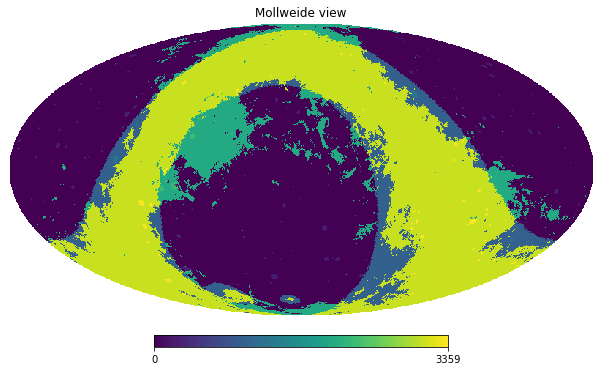

In [13]:
hp.mollview(x)

In [14]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    ra = h5r['RA'][:]
    dec = h5r['DEC'][:]

In [15]:
nside=4096
phi = ra/180*np.pi
theta = (90.-dec)/180*np.pi

pix = hp.ang2pix(nside, theta, phi)
foreground = x[pix]

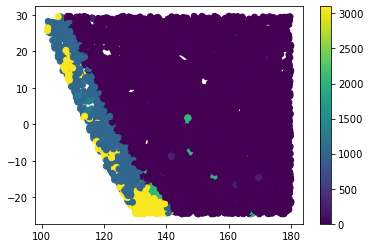

In [16]:
ids = np.arange(len(pix))
np.random.shuffle(ids)
mplot.scatter(ra[ids[:10000]], dec[ids[:10000]], c=foreground[ids[:10000]])
mplot.colorbar()

In [17]:
# with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'a') as h5r:
#      h5r.create_dataset('FLAGS_FOREGROUND', data = foreground)

### Now calculate weights and put in as a column, commented out when it's done

Follow Y6 and do " total shape noise of sample + the measurement error from metacal" instead of the Y3 method of binning the galaxies in size ratio and s/n bins. Note that this can be done uncalibrated since it cancels out when we are interested in relative weights.

In [4]:
# first get mask total

with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    size_ratio = h5r['mcal_T_ratio_noshear'][:]
    s2n = h5r['mcal_s2n_noshear'][:]
    sg = h5r['sg_bdf'][:] 
    fg = h5r['FLAGS_FOREGROUND'][:] 
    T = h5r['mcal_T_noshear'][:]
    mcal_flags = h5r['mcal_flags'][:]
    g1, g2  = h5r['mcal_g_noshear'][:].T
    flux_r, flux_i, flux_z = h5r['mcal_flux_noshear'][:].T

mag_r = -2.5*np.log10(flux_r)+30
mag_i = -2.5*np.log10(flux_i)+30
mag_z = -2.5*np.log10(flux_z)+30

# PZ mask
mcal_pz_mask = ((mag_i < 23.5) & (mag_i > 18) & 
                    (mag_r < 26)   & (mag_r > 15) & 
                    (mag_z < 26)   & (mag_z > 15) & 
                    (mag_r - mag_i < 4)   & (mag_r - mag_i > -1.5) & 
                    (mag_i - mag_z < 4)   & (mag_i - mag_z > -1.5))

# Metacal cuts based on DES Y3 ones (from here: https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)
SNR_Mask   = (s2n > 10) & (s2n < 1000)
Tratio_Mask= size_ratio > 0.5
T_Mask = T < 10
Flag_Mask = (mcal_flags == 0)
Other_Mask = np.invert((T > 2) & (s2n < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))
SG_Mask = (sg>=4)
FG_Mask = (fg==0)

mask_total = mcal_pz_mask & SNR_Mask & Tratio_Mask & T_Mask & Flag_Mask & Other_Mask & SG_Mask & FG_Mask

del size_ratio, s2n, sg, fg, T, mcal_flags, g1, g2, flux_r, flux_i, flux_z, mag_r, mag_i, mag_z
del mcal_pz_mask, SNR_Mask, Tratio_Mask, T_Mask, Flag_Mask, Other_Mask, SG_Mask

/project/chihway/yomori/repo/anaconda3/envs/cosmosis/lib/python3.7/site-packages/ipykernel_launcher.py:13: RuntimeWarning: invalid value encountered in log10
  del sys.path[0]
/project/chihway/yomori/repo/anaconda3/envs/cosmosis/lib/python3.7/site-packages/ipykernel_launcher.py:14: RuntimeWarning: invalid value encountered in log10
  
/project/chihway/yomori/repo/anaconda3/envs/cosmosis/lib/python3.7/site-packages/ipykernel_launcher.py:15: RuntimeWarning: invalid value encountered in log10
  from ipykernel import kernelapp as app
/project/chihway/yomori/repo/anaconda3/envs/cosmosis/lib/python3.7/site-packages/ipykernel_launcher.py:29: RuntimeWarning: invalid value encountered in log10


In [5]:
print('original', len(sg), '('+str(len(sg)/len(sg))+')')
print('mcal pz mask', len(sg[mcal_pz_mask]), '('+str(len(sg[mcal_pz_mask])/len(sg))+')')
print('SNR mask', len(sg[SNR_Mask]), '('+str(len(sg[SNR_Mask])/len(sg))+')')
print('T ratio mask', len(sg[Tratio_Mask]), '('+str(len(sg[Tratio_Mask])/len(sg))+')')
print('T mask', len(sg[T_Mask]), '('+str(len(sg[T_Mask])/len(sg))+')')
print('flag mask', len(sg[Flag_Mask]), '('+str(len(sg[Flag_Mask])/len(sg))+')')
print('other mask', len(sg[Other_Mask]), '('+str(len(sg[Other_Mask])/len(sg))+')')
print('s/g mask', len(sg[SG_Mask]), '('+str(len(sg[SG_Mask])/len(sg))+')')
print('foreground mask', len(sg[FG_Mask]), '('+str(len(sg[FG_Mask])/len(sg))+')')
print('total mask', len(sg[mask_total]), '('+str(len(sg[mask_total])/len(sg))+')')

NameError: name 'sg' is not defined

In [6]:
# first read shear catalog, place fiducial cuts, calibrate as a full sample

with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    mcal_g = h5r['mcal_g_noshear'][:][mask_total]
    mcal_g_cov = h5r['mcal_g_cov_noshear'][:]
    # note we don't cut on covariance since we need to store it back as one number for all galaxies

In [7]:
e1 = mcal_g[:,0] 
e2 = mcal_g[:,1] 

sig_e_squared = 0.5*(np.sum(e1**2)/len(e1) + np.sum(e2**2)/len(e1))
print('raw shape noise', sig_e_squared, sig_e_squared**0.5)

raw shape noise 0.03814300597829457 0.1953023450404387


In [8]:
mcal_g1_var_mea = mcal_g_cov[:,0,0] 
mcal_g1_var = mcal_g1_var_mea + sig_e_squared
mcal_g1_w = 1./mcal_g1_var

mcal_g2_var_mea = mcal_g_cov[:,1,1] 
mcal_g2_var = mcal_g2_var_mea + sig_e_squared
mcal_g2_w = 1./mcal_g2_var

In [9]:
# len(mcal_g1_var_mea), len(mask_total)

26.217126163812416


Text(0.5, 1.0, 'weights for g1 and g2')

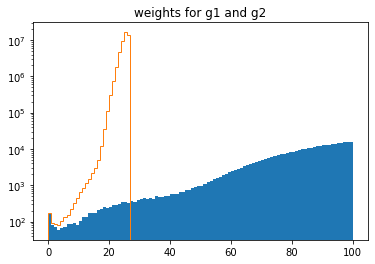

In [10]:
mplot.hist(1./mcal_g1_var_mea[mask_total], bins=100, range=(0.01,100))
mplot.hist(1./(mcal_g1_var_mea[mask_total]+ sig_e_squared), bins=100, range=(0.01,100), histtype='step')

print(1./sig_e_squared)
# mplot.xscale('log')
mplot.yscale('log')

mplot.title('weights for g1 and g2')

Text(0.5, 1.0, 'weights for g1 and g2')

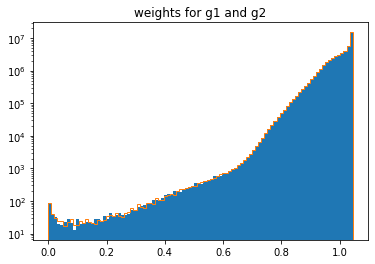

In [11]:
mplot.hist(mcal_g1_w[mask_total]/np.sum(mcal_g1_w[mask_total])*len(mcal_g1_w[mask_total]), bins=100)
mplot.hist(mcal_g2_w[mask_total]/np.sum(mcal_g2_w[mask_total])*len(mcal_g1_w[mask_total]), bins=100, histtype='step')

mplot.yscale('log')
mplot.title('weights for g1 and g2')

In [12]:
# with h5py.File('/project2/chihway/data/decade/metacal_gold_combined_2023'+tag+'.hdf', 'a') as h5r:
#     #      h5r['mcal_g_w'][:] = (mcal_g1_w+mcal_g2_w)/2
#      h5r.create_dataset('mcal_g_w', data = (mcal_g1_w+mcal_g2_w)/2)

### Make weight as a function of size/S2N plot 

In [13]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    size_ratio = h5r['mcal_T_ratio_noshear'][:]
    s2n = h5r['mcal_s2n_noshear'][:]


In [14]:
# determine what grid to use
print(len(s2n), len(s2n[mask_total]), len(s2n[mask_total*(size_ratio>0.5)*(size_ratio<6)*(s2n>10)*(s2n<400)]))
print(len(s2n[mask_total*(size_ratio>0.5)*(size_ratio<6)*(s2n>10)*(s2n<400)])/len(s2n[mask_total]))

244200019 47349243 46165723
0.9750044578326205


In [15]:
size_ratio_grid = np.logspace(np.log10(0.5), np.log10(6), 21)
s2n_grid = np.logspace(np.log10(10), np.log10(400), 21)
size_ratio_grid2 = [str(xx)[:4] for xx in size_ratio_grid]
s2n_grid2 = [str(xx)[:4] for xx in s2n_grid]

In [16]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    w = h5r['mcal_g_w'][mask_total]
    size_ratio = h5r['mcal_T_ratio_noshear'][mask_total]
    s2n = h5r['mcal_s2n_noshear'][mask_total]
    g1, g2  = h5r['mcal_g_noshear'][:][mask_total].T
    mcal_g_cov = h5r['mcal_g_cov_noshear'][:][mask_total]


In [17]:
weight_grid = np.zeros((20,20))
weight_grid_m = np.zeros((20,20))
e1_grid = np.zeros((20,20))
e2_grid = np.zeros((20,20))
R_grid = np.zeros((20,20))

for i in range(20):
    for j in range(20):
        mask_bin = (size_ratio>=size_ratio_grid[i])*(size_ratio<size_ratio_grid[i+1])*(s2n>=s2n_grid[j])*(s2n<s2n_grid[j+1])
        weight_grid[i][j] = np.mean(w[mask_bin])
        weight_grid_m[i][j] = np.mean(1./mcal_g_cov[:,0,0][mask_bin])
        e1_grid[i][j] = np.sqrt(np.mean(g1[mask_bin]**2))
        e2_grid[i][j] = np.sqrt(np.mean(g2[mask_bin]**2))


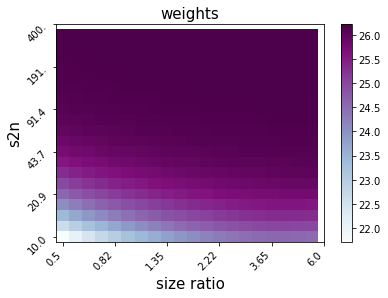

In [18]:
mplot.imshow(weight_grid.T, cmap='BuPu', origin='lower', aspect='auto')
mplot.xticks(np.arange(21)[::4], size_ratio_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.yticks(np.arange(21)[::4], s2n_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.title('weights', fontsize=15)
mplot.xlabel('size ratio', fontsize=15)
mplot.ylabel('s2n', fontsize=15)
mplot.colorbar()

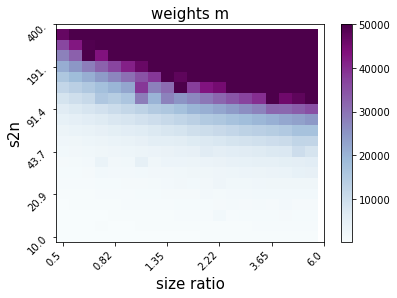

In [19]:
mplot.imshow(weight_grid_m.T, cmap='BuPu', origin='lower', aspect='auto')
mplot.xticks(np.arange(21)[::4], size_ratio_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.yticks(np.arange(21)[::4], s2n_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.title('weights m', fontsize=15)
mplot.xlabel('size ratio', fontsize=15)
mplot.ylabel('s2n', fontsize=15)
mplot.colorbar()
mplot.clim(np.min(weight_grid_m), 50000)

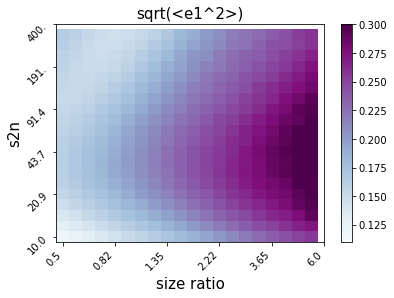

In [20]:
mplot.imshow(e1_grid.T, cmap='BuPu', origin='lower', aspect='auto')
mplot.xticks(np.arange(21)[::4], size_ratio_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.yticks(np.arange(21)[::4], s2n_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.title('sqrt(<e1^2>)', fontsize=15)
mplot.xlabel('size ratio', fontsize=15)
mplot.ylabel('s2n', fontsize=15)
mplot.colorbar()
mplot.clim(0.11,0.3)

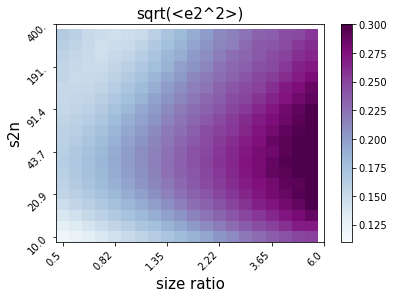

In [21]:
mplot.imshow(e2_grid.T, cmap='BuPu', origin='lower', aspect='auto')
mplot.xticks(np.arange(21)[::4], size_ratio_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.yticks(np.arange(21)[::4], s2n_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.title('sqrt(<e2^2>)', fontsize=15)
mplot.xlabel('size ratio', fontsize=15)
mplot.ylabel('s2n', fontsize=15)
mplot.colorbar()
mplot.clim(0.11,0.3)

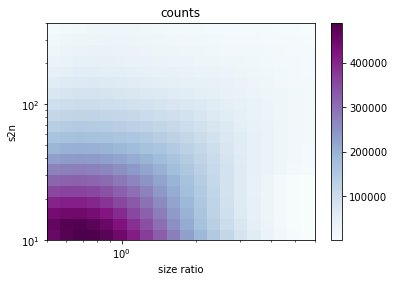

In [22]:
X = mplot.hist2d(size_ratio, s2n, bins=(size_ratio_grid, s2n_grid), cmap='BuPu')
mplot.xscale('log')
mplot.yscale('log')
mplot.xlabel('size ratio')
mplot.ylabel('s2n')
mplot.title('counts')
mplot.colorbar()

### Second way of doing weights

We calculate this in code/response_s2n_size, here is just reading in the values. Also save to file.

In [23]:
size_ratio_grid = np.logspace(np.log10(0.5), np.log10(6), 21)
s2n_grid = np.logspace(np.log10(10), np.log10(400), 21)
size_ratio_grid2 = [str(xx)[:4] for xx in size_ratio_grid]
s2n_grid2 = [str(xx)[:4] for xx in s2n_grid]

In [24]:

counts = np.zeros((20,20))
sigma_e2 = np.zeros((20,20))
sigma_e2_m = np.zeros((20,20))
R11 = np.zeros((20,20))
R11s = np.zeros((20,20))
R22 = np.zeros((20,20))
R22s = np.zeros((20,20))

for i in range(20):
    for j in range(20):
        X = np.loadtxt('/project/chihway/chihway/shearcat/shear_catalog/response_s2n_size/response_'+str(i)+'_'+str(j)+'.txt')
        
        counts[i][j] = X[0]
        R11[i][j] = X[1]
        R11s[i][j] = X[2]
        R22[i][j] = X[3]
        R22s[i][j] = X[4]
        sigma_e2[i][j] = X[5]
        sigma_e2_m[i][j] = X[6]  

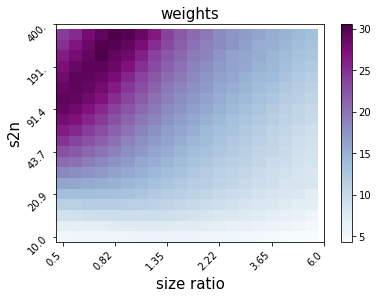

In [25]:
R_gamma = (R11+R22)/2
sigma_e_all = (sigma_e2*counts).copy()
ww = (1./(sigma_e_all*R_gamma**(-2))).T
mplot.imshow(ww, cmap='BuPu', origin='lower', aspect='auto')
mplot.xticks(np.arange(21)[::4], size_ratio_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.yticks(np.arange(21)[::4], s2n_grid2[::4], rotation=45, fontsize='10', horizontalalignment='right')
mplot.title('weights', fontsize=15)
mplot.xlabel('size ratio', fontsize=15)
mplot.ylabel('s2n', fontsize=15)
mplot.colorbar()

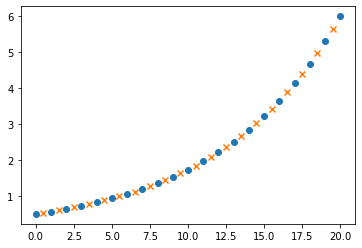

In [26]:
size_ratio_grid = np.logspace(np.log10(0.5), np.log10(6), 21)
size_ratio_grid_center = np.logspace(np.log10(0.5), np.log10(6), 41)[1:][::2]

s2n_grid = np.logspace(np.log10(10), np.log10(400), 21)
s2n_grid_center = np.logspace(np.log10(10), np.log10(400), 41)[1:][::2]

mplot.scatter(np.arange(21), size_ratio_grid)
mplot.scatter(np.arange(20)+0.5, size_ratio_grid_center, marker='x')

In [27]:
xx, yy = np.meshgrid(size_ratio_grid_center, s2n_grid_center)

In [28]:
from scipy.interpolate import griddata

w_v2 = griddata(np.array([xx.flatten(),yy.flatten()]).T, ww.flatten(), (size_ratio[:10000], s2n[:10000]), method='nearest')



(10, 100)

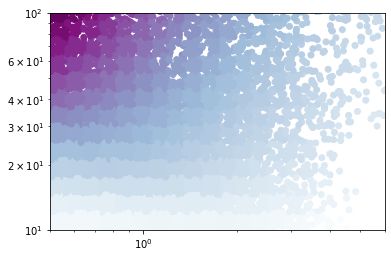

In [29]:
mplot.scatter(size_ratio[:10000], s2n[:10000], c=w_v2, cmap='BuPu')
mplot.xscale('log')
mplot.yscale('log')
mplot.xlim(0.5,6)
mplot.ylim(10,100)
# print(w_v2)


In [30]:
w_v2 = griddata(np.array([xx.flatten(),yy.flatten()]).T, ww.flatten(), (size_ratio, s2n), method='nearest')

In [31]:
# mplot.hist(w_v2, bins=100)

In [32]:
# with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'a') as h5r:
#     del h5r['mcal_g_w_v2']
#     h5r.create_dataset('mcal_g_w_v2', data = w_v2)

In [33]:
len(w_v2), len(s2n)

(47349243, 47349243)

## Now once the file has all the columns, let's look at a rough fiducial sample

In [34]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    ra = h5r['RA'][:]
    dec = h5r['DEC'][:]

In [35]:
nside = 4096
map_counts = np.zeros(hp.nside2npix(nside))

phi = ra[mask_total]/180*np.pi
theta = (90.-dec[mask_total])/180*np.pi

pix = hp.ang2pix(nside, theta, phi)

In [ ]:
for i in range(len(pix)):
    map_counts[pix[i]] += 1

In [ ]:
area = len(map_counts[map_counts>0])/len(map_counts)*4*np.pi*(180./np.pi)**2*60*60
print('area', area/60/60, 'deg^2')

In [ ]:
print('total', len(ra[mask_total])/area, '/arcmin^2')

## Calculate shear calibration

In [ ]:
Mask = {}

In [ ]:
for shear_type in ['noshear', '1p', '1m', '2p', '2m']: 
    with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
        sg = h5r['sg_bdf'][:] 
        fg = h5r['FLAGS_FOREGROUND'][:] 
        T = h5r['mcal_T_'+shear_type][:]
        s2n = h5r['mcal_s2n_'+shear_type][:]
        size_ratio = h5r['mcal_T_ratio_'+shear_type][:]
        mcal_flags = h5r['mcal_flags'][:]
        flux_r, flux_i, flux_z = h5r['mcal_flux_'+shear_type][:].T
        g1, g2  = h5r['mcal_g_'+shear_type][:].T
        
    mag_r = -2.5*np.log10(flux_r)+30
    mag_i = -2.5*np.log10(flux_i)+30
    mag_z = -2.5*np.log10(flux_z)+30

    # PZ mask
    mcal_pz_mask = ((mag_i < 23.5) & (mag_i > 18) & 
                        (mag_r < 26)   & (mag_r > 15) & 
                        (mag_z < 26)   & (mag_z > 15) & 
                        (mag_r - mag_i < 4)   & (mag_r - mag_i > -1.5) & 
                        (mag_i - mag_z < 4)   & (mag_i - mag_z > -1.5))

    # Metacal cuts based on DES Y3 ones (from here: https://des.ncsa.illinois.edu/releases/y3a2/Y3key-catalogs)
    SNR_Mask   = (s2n > 10) & (s2n < 1000)
    Tratio_Mask= size_ratio > 0.5
    T_Mask = T < 10
    Flag_Mask = (mcal_flags == 0)
    Other_Mask = np.invert((T > 2) & (s2n < 30)) & np.invert((np.log10(T) < (22.25 - mag_r)/3.5) & (g1**2 + g2**2 > 0.8**2))
    SG_Mask = (sg>=4)
    FG_Mask = (fg==0)

    mask_total_X = mcal_pz_mask & SNR_Mask & Tratio_Mask & T_Mask & Flag_Mask & Other_Mask & SG_Mask & FG_Mask
    
    Mask[shear_type] = mask_total_X
    del T
    del s2n
    del size_ratio
    del sg
    del fg
    del flux_r, flux_i, flux_z
    del mag_r, mag_i, mag_z

In [ ]:
def weight_average(values, weights):
    return np.sum(values*weights)/np.sum(weights)

In [ ]:
dgamma = 2*0.01
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:

    R11 =  (weight_average(h5r['mcal_g_1p'][:,0][Mask['noshear']],h5r['mcal_g_w'][Mask['noshear']]) - weight_average(h5r['mcal_g_1m'][:,0][Mask['noshear']], h5r['mcal_g_w'][Mask['noshear']]))/dgamma
    R11s = (weight_average(h5r['mcal_g_noshear'][:,0][Mask['1p']], h5r['mcal_g_w'][Mask['1p']]) - weight_average(h5r['mcal_g_noshear'][:,0][Mask['1m']], h5r['mcal_g_w'][Mask['1m']]))/dgamma
    R22 =  (weight_average(h5r['mcal_g_2p'][:,1][Mask['noshear']], h5r['mcal_g_w'][Mask['noshear']]) - weight_average(h5r['mcal_g_2m'][:,1][Mask['noshear']], h5r['mcal_g_w'][Mask['noshear']]))/dgamma
    R22s = (weight_average(h5r['mcal_g_noshear'][:,1][Mask['2p']], h5r['mcal_g_w'][Mask['2p']]) - weight_average(h5r['mcal_g_noshear'][:,1][Mask['2m']], h5r['mcal_g_w'][Mask['2m']]))/dgamma
    R11tot = R11+R11s
    R22tot = R22+R22s
    
    print('R11', R11, 'R11s', R11s)
    print('R22', R22, 'R22s', R22s)
    print('R11tot', R11tot, 'R22tot', R22tot)

In [ ]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    R11 =  (weight_average(h5r['mcal_g_1p'][:,0][Mask['noshear']], h5r['mcal_g_w_v2'][Mask['noshear']]) - weight_average(h5r['mcal_g_1m'][:,0][Mask['noshear']], h5r['mcal_g_w_v2'][Mask['noshear']]))/dgamma
    R11s = (weight_average(h5r['mcal_g_noshear'][:,0][Mask['1p']], h5r['mcal_g_w_v2'][Mask['1p']]) - weight_average(h5r['mcal_g_noshear'][:,0][Mask['1m']], h5r['mcal_g_w_v2'][Mask['1m']]))/dgamma
    R22 =  (weight_average(h5r['mcal_g_2p'][:,1][Mask['noshear']], h5r['mcal_g_w_v2'][Mask['noshear']]) - weight_average(h5r['mcal_g_2m'][:,1][Mask['noshear']], h5r['mcal_g_w_v2'][Mask['noshear']]))/dgamma
    R22s = (weight_average(h5r['mcal_g_noshear'][:,1][Mask['2p']], h5r['mcal_g_w_v2'][Mask['2p']]) - weight_average(h5r['mcal_g_noshear'][:,1][Mask['2m']], h5r['mcal_g_w_v2'][Mask['2m']]))/dgamma
    R11tot = R11+R11s
    R22tot = R22+R22s
    
    print('R11', R11, 'R11s', R11s)
    print('R22', R22, 'R22s', R22s)
    print('R11tot', R11tot, 'R22tot', R22tot)


## Make a bunch of maps with noshear quantities from shear catalog

In [6]:
with h5py.File(project_dir+'metacal_gold_combined_2023'+tag+'.hdf', 'r') as h5r:
    ra = h5r['RA'][mask_total]
    dec = h5r['DEC'][mask_total]
    size_ratio = h5r['mcal_T_ratio_noshear'][mask_total]
    psf_e = h5r['mcal_psf_g_noshear'][:][mask_total]
    s2n = h5r['mcal_s2n_noshear'][mask_total]
    w = h5r['mcal_g_w_v2'][mask_total]

In [17]:
nside = 4096
map_counts = np.zeros(hp.nside2npix(nside))
map_weights = np.zeros(hp.nside2npix(nside))
map_psf_e1 = np.zeros(hp.nside2npix(nside))
map_psf_e2 = np.zeros(hp.nside2npix(nside))
map_size_ratio = np.zeros(hp.nside2npix(nside))
map_s2n = np.zeros(hp.nside2npix(nside))

phi = ra/180*np.pi
theta = (90.-dec)/180*np.pi

pix = hp.ang2pix(nside, theta, phi)

In [18]:
for i in range(len(pix)):
    map_counts[pix[i]] += 1
    map_weights[pix[i]] += w[i]
    map_size_ratio[pix[i]] += size_ratio[i]*w[i]
    map_s2n[pix[i]] += s2n[i]*w[i]
    map_psf_e1[pix[i]] += psf_e[i,0]*w[i]
    map_psf_e2[pix[i]] += psf_e[i,1]*w[i]

In [19]:
# plot bright stars on mask to see if it's working as intended
f = pf.open('/project/chihway/dhayaa/DECADE/bsc5p_bright_stars.fits')[1].data

0.0 180.0 -180.0 180.0


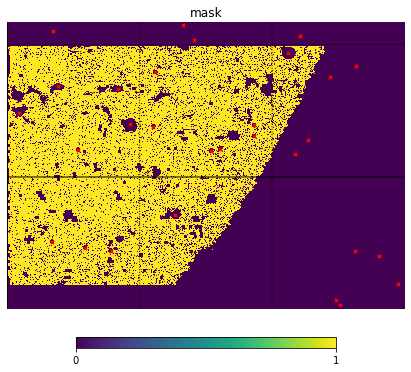

In [20]:
mask_fid = map_counts.copy()
mask_fid[mask_fid>0] = 1
hp.cartview(mask_fid, lonra=[90,180], latra=[-30,35],title='mask')
hp.projscatter(f['ra'], f['dec'], lonlat = True, s = 10, marker='x', color = 'r')
hp.graticule()

0.0 180.0 -180.0 180.0


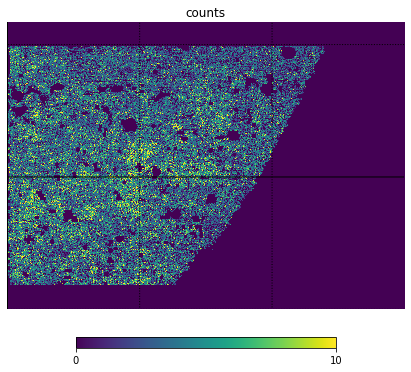

In [21]:
hp.cartview(map_counts, lonra=[90,180], latra=[-30,35], min=0, max=10, title='counts')
hp.graticule()

/project/chihway/yomori/repo/anaconda3/envs/cosmosis/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
0.0 180.0 -180.0 180.0


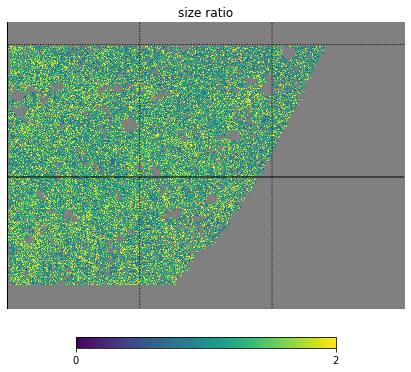

In [22]:
hp.cartview(map_size_ratio/map_weights, lonra=[90,180], latra=[-30,35], min=0, max=2, title='size ratio')
hp.graticule()

/project/chihway/yomori/repo/anaconda3/envs/cosmosis/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
0.0 180.0 -180.0 180.0


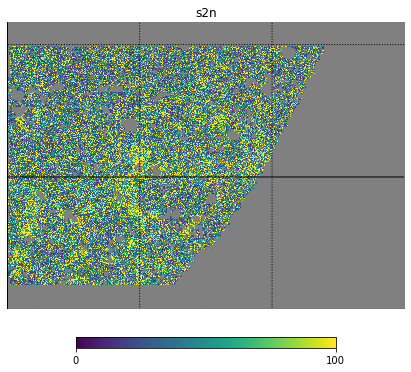

In [23]:
hp.cartview(map_s2n/map_weights, lonra=[90,180], latra=[-30,35], min=0, max=100, title='s2n')
hp.graticule()

/project/chihway/yomori/repo/anaconda3/envs/cosmosis/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
0.0 180.0 -180.0 180.0


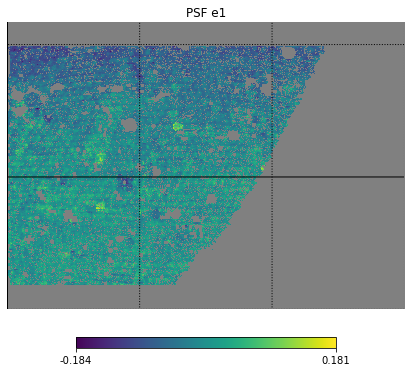

In [24]:
hp.cartview(map_psf_e1/map_weights, lonra=[90,180], latra=[-30,35], title='PSF e1')
hp.graticule()

/project/chihway/yomori/repo/anaconda3/envs/cosmosis/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
0.0 180.0 -180.0 180.0


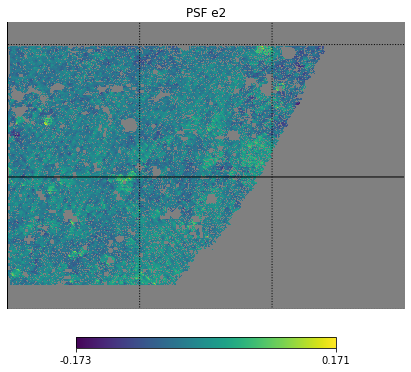

In [25]:
hp.cartview(map_psf_e2/map_weights, lonra=[90,180], latra=[-30,35], title='PSF e2')
hp.graticule()

In [26]:
def divide_map(map1, map2):
    outmap = map1.copy()
    outmap[map2>0] /= map2[map2>0]
    outmap[map2==0] = hp.UNSEEN
    return outmap

In [28]:
map_dir = '/project/chihway/data/decade/SP_maps/mcal/'
hp.write_map(map_dir+'ncounts_2023'+tag+'.fits', map_counts, overwrite=True)
hp.write_map(map_dir+'psf_e1_2023'+tag+'.fits', divide_map(map_psf_e1,map_weights), overwrite=True)
hp.write_map(map_dir+'psf_e2_2023'+tag+'.fits', divide_map(map_psf_e2,map_weights), overwrite=True)
hp.write_map(map_dir+'size_ratio_2023'+tag+'.fits', divide_map(map_size_ratio,map_weights), overwrite=True)
hp.write_map(map_dir+'s2n_2023'+tag+'.fits', divide_map(map_s2n,map_weights), overwrite=True)

setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]
setting the output map dtype to [dtype('float64')]


## Some investigation of the gridding pattern in the PSF ellipticity maps

/tmp/jobs/27624000/ipykernel_38902/3181526985.py:1: RuntimeWarning: invalid value encountered in true_divide
  hp.cartview(map_psf_e1/map_counts, lonra=[120,180], latra=[-20,0], title='PSF e1')


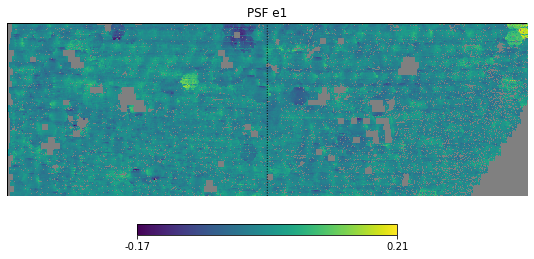

In [15]:
hp.cartview(map_psf_e1/map_counts, lonra=[120,180], latra=[-20,0], title='PSF e1')
hp.graticule()

/tmp/jobs/27624000/ipykernel_38902/1825602356.py:1: RuntimeWarning: invalid value encountered in true_divide
  hp.cartview(map_psf_e2/map_counts, lonra=[90,180], latra=[-30,35], title='PSF e2')


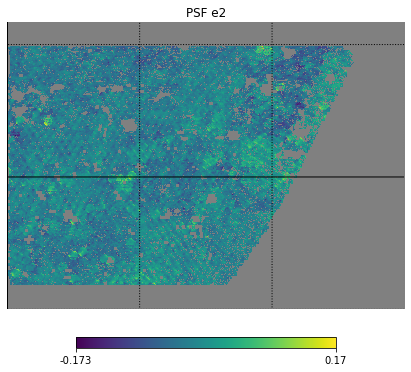

In [16]:
hp.cartview(map_psf_e2/map_counts, lonra=[90,180], latra=[-30,35], title='PSF e2')
hp.graticule()

In [17]:
tile_list = pf.open('/project2/chihway/data/decade/decam-tiles-bliss-v1.fits.gz')

In [18]:
print(tile_list[1].header.keys)

<bound method Header.keys of XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                   26 / width of table in bytes                        
NAXIS2  =                63488 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                    8 / number of fields in each row                   
TTYPE1  = 'TILEID  '           / label for field   1                            
TFORM1  = 'J       '           / data format of field: 4-byte INTEGER           
TTYPE2  = 'PASS    '           / label for field   2                            
TFORM2  = 'I       '           / data format of field: 2-byte INTEGER           

In [19]:
mask = (tile_list[1].data['pass']==1)
ra_tile = tile_list[1].data['ra'][mask]
dec_tile = tile_list[1].data['dec'][mask]
print(tile_list[1].data['pass'])

[1 1 1 ... 4 4 4]


/tmp/jobs/27624000/ipykernel_38902/1288674342.py:1: RuntimeWarning: invalid value encountered in true_divide
  hp.cartview(map_psf_e1/map_counts, lonra=[90,180], latra=[-30,35], title='PSF e1')


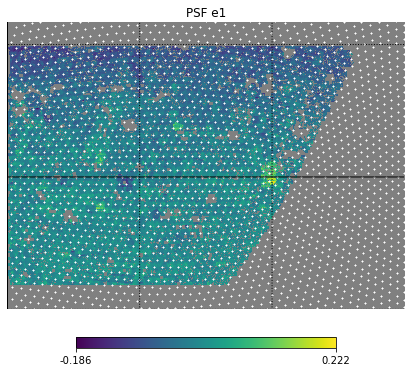

In [39]:
hp.cartview(map_psf_e1/map_counts, lonra=[90,180], latra=[-30,35], title='PSF e1')
#hp.mollview(map_psf_e1/map_counts)
hp.projscatter(ra_tile, dec_tile, color='w', s=1, marker='x', lonlat=True)
hp.graticule()

In [55]:
ids = np.arange(len(ra_map[map_counts>0]))
np.random.shuffle(ids)

/tmp/jobs/27624000/ipykernel_38902/1664470758.py:3: RuntimeWarning: invalid value encountered in true_divide
  mplot.hist2d(ra_map[map_counts>0][ids[:300000]], dec_map[map_counts>0][ids[:300000]], weights=(map_psf_e1/map_counts)[map_counts>0][ids[:300000]], bins=(500,400))


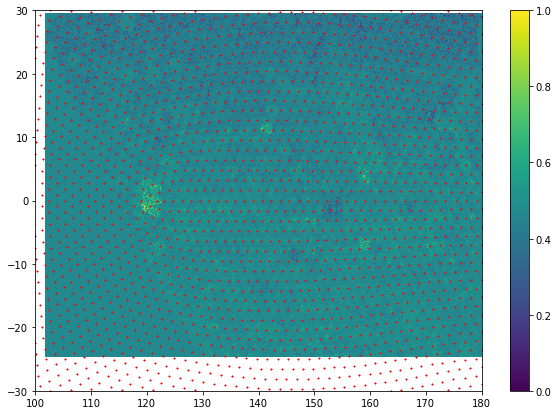

In [72]:
mplot.figure(figsize=(10,7))
# mplot.scatter(ra_map[map_counts>0][ids[:300000]], dec_map[map_counts>0][ids[:300000]], c=(map_psf_e1/map_counts)[map_counts>0][ids[:300000]], s=1, marker='.')
mplot.hist2d(ra_map[map_counts>0][ids[:300000]], dec_map[map_counts>0][ids[:300000]], weights=(map_psf_e1/map_counts)[map_counts>0][ids[:300000]], bins=(500,400))

mplot.scatter(ra_tile, dec_tile, color='r', s=1, marker='x')
mplot.xlim(100,180)
mplot.ylim(-30,30)
mplot.colorbar()

In [51]:
len(map_counts), len(ra_map)

(201326592, 59919130)

## check if similar gridding patterns are in Y1

In [25]:
desy1 = pf.open('/project2/chihway/data/des_y1_catalogs/mcal-y1a1-combined-riz-unblind-v4-matched.fits')
desy1[1].header

XTENSION= 'BINTABLE'           / binary table extension                         
BITPIX  =                    8 / 8-bit bytes                                    
NAXIS   =                    2 / 2-dimensional binary table                     
NAXIS1  =                  614 / width of table in bytes                        
NAXIS2  =            136930995 / number of rows in table                        
PCOUNT  =                    0 / size of special data area                      
GCOUNT  =                    1 / one data group (required keyword)              
TFIELDS =                   80 / number of fields in each row                   
TTYPE1  = 'coadd_objects_id'   / label for field   1                            
TFORM1  = 'K       '           / data format of field: 8-byte INTEGER           
TTYPE2  = 'flags   '           / label for field   2                            
TFORM2  = 'J       '           / data format of field: 4-byte INTEGER           
TTYPE3  = 'mask_frac'       

In [26]:
mask = (desy1[1].data['flags']==0)
ra_mask = desy1[1].data['ra'][mask]
dec_mask = desy1[1].data['dec'][mask]
psf_e1_mask = desy1[1].data['psf_e1'][mask]
psf_e2_mask = desy1[1].data['psf_e2'][mask]

In [27]:
nside = 4096
map_counts = np.zeros(hp.nside2npix(nside))
map_psf_e1 = np.zeros(hp.nside2npix(nside))
map_psf_e2 = np.zeros(hp.nside2npix(nside))

phi = ra_mask/180*np.pi
theta = (90.-dec_mask)/180*np.pi

pix = hp.ang2pix(nside, theta, phi)

In [28]:
for i in range(len(pix)):
    map_counts[pix[i]] += 1
    map_psf_e1[pix[i]] += psf_e1_mask[i]
    map_psf_e2[pix[i]] += psf_e2_mask[i]
 

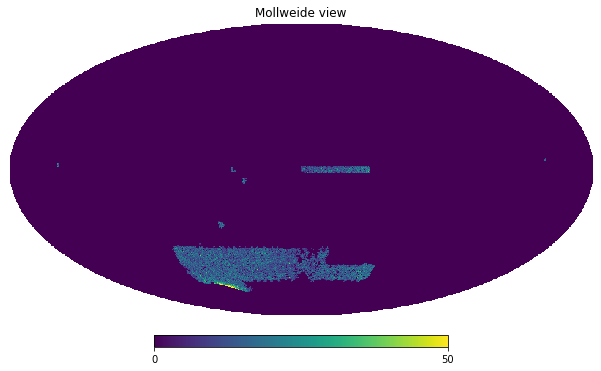

In [29]:
hp.mollview(map_counts,min=0,max=50)

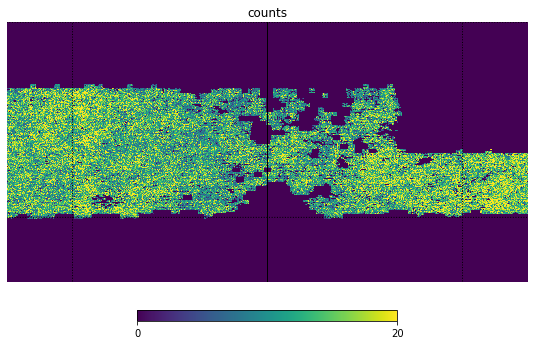

In [30]:
hp.cartview(map_counts, lonra=[-40,40], latra=[-70,-30], min=0, max=20, title='counts')
hp.graticule()

/tmp/jobs/27622198/ipykernel_6734/1944693814.py:1: RuntimeWarning: invalid value encountered in true_divide
  hp.cartview(map_psf_e1/map_counts, lonra=[-40,40], latra=[-60,-40], title='psf e1')


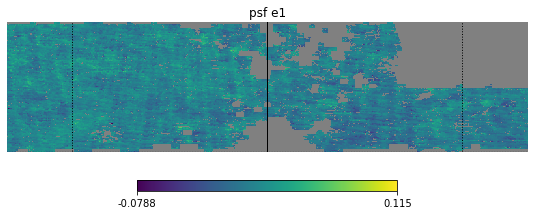

In [92]:

hp.cartview(map_psf_e1/map_counts, lonra=[-40,40], latra=[-60,-40], title='psf e1')
hp.graticule()

/tmp/jobs/27622198/ipykernel_6734/2151345328.py:1: RuntimeWarning: invalid value encountered in true_divide
  hp.cartview(map_psf_e2/map_counts, lonra=[-40,40], latra=[-60,-40], title='psf e1')


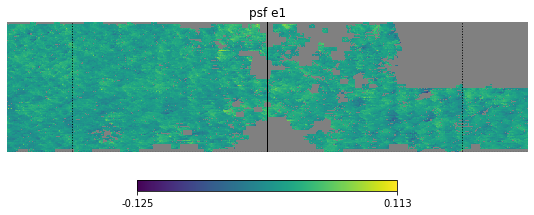

In [93]:
hp.cartview(map_psf_e2/map_counts, lonra=[-40,40], latra=[-60,-40], title='psf e1')
hp.graticule()